# Social Graphs and Interactions: Assignment 02

**Date:** November 11, 2024

**Created by:**  
Johan Böcher Hanehøj (s194495), Melis Cemre Akyol (s232165), Md Jahidul Islam (s240010)


# Part 1: Genres and communities and plotting #

**Write about genres and modularity.**

Modularity, a measure of network community structure, is used to assess whether genre-based partitions represent meaningful groupings. High modularity would indicate that genres align well with densely connected artist communities, suggesting genres significantly shape artist connections. In contrast, low modularity implies weak or nonexistent genre-based communities, questioning the role of genre as a defining characteristic in this network.

**Detect the communities, discuss the value of modularity in comparison to the genres.**

In [29]:
import networkx as nx
import json

# Load the existing Country Musician network
G = nx.read_graphml(r"D:\DTU\2nd Sem\SGAI\country music graph\country_musician_graph.graphml")

In [31]:
import networkx as nx
import ast
import requests

# Step 1: Load Your Graph
G = nx.read_graphml(r"D:\DTU\2nd Sem\SGAI\country music graph\country_musician_graph.graphml")
G = G.to_undirected()

# Step 2: Load the Artist-Genre Data from the .txt file
url = "https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2024/refs/heads/main/files/artists_genres_dictionary.txt"
response = requests.get(url)
artist_genres_data = ast.literal_eval(response.text)  # Convert the text data to a dictionary

# Prepare a mapping of artist to their first genre
artist_genres = {}
for artist, genres in artist_genres_data.items():
    if genres:
        artist_name = artist.replace(' ', '_')
        artist_genres[artist_name] = genres[0]

# Step 3: Assign Communities Based on Genres
community_dict = {}
for node in G.nodes():
    if node in artist_genres:
        community_dict[node] = artist_genres[node]
    else:
        # Optionally remove nodes without genre information
        community_dict[node] = None

# Remove nodes without genre information
nodes_to_remove = [node for node, genre in community_dict.items() if genre is None]
G.remove_nodes_from(nodes_to_remove)

# Update the community dictionary
community_dict = {node: genre for node, genre in community_dict.items() if genre is not None}

# Update degrees after removing nodes
degrees = dict(G.degree())

# Total number of edges
m = G.number_of_edges()
print(f"Total number of edges in the network: {m}")

# Step 4: Calculate Modularity Using Edge Iteration
M = 0.0

for u, v in G.edges():
    k_u = degrees[u]
    k_v = degrees[v]
    delta = 1 if community_dict[u] == community_dict[v] else 0
    M += (1 - (k_u * k_v) / (2 * m)) * delta

M /= (2 * m)

print(f"The modularity M of the network partitioned by genres is: {M:.4f}")

# Step 5: Interpret the Modularity Value
if M > 0.3:
    print("Genres represent strong communities.")
elif M > 0:
    print("Genres represent weak communities.")
else:
    print("Genres do not represent good communities.")


Total number of edges in the network: 14383
The modularity M of the network partitioned by genres is: 0.2413
Genres represent weak communities.


In [33]:
# After removing nodes without genre information
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 1832
Number of edges: 14383


In [35]:
import networkx as nx
import json
import community as community_louvain
import matplotlib.pyplot as plt
from collections import Counter


# Replace spaces with underscores in artist names
artist_genres = {artist.replace(' ', '_'): genres for artist, genres in artist_genres_data.items()}

# Filter out nodes without genre information
nodes_with_genre = set(artist_genres.keys())
nodes_to_remove = [node for node in G.nodes if node not in nodes_with_genre]
G.remove_nodes_from(nodes_to_remove)

# Remove isolated nodes
isolated_nodes = list(nx.isolates(G))
print(f"Removing {len(isolated_nodes)} isolated nodes")
G.remove_nodes_from(isolated_nodes)

# Verify the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Check connectivity
is_connected = nx.is_connected(G)
num_components = nx.number_connected_components(G)
print(f"Is the graph connected? {is_connected}")
print(f"Number of connected components: {num_components}")
# Adjust the resolution parameter
resolution = 2  # Adjust this value as needed
partition = community_louvain.best_partition(G)
num_communities = len(set(partition.values()))
modularity = community_louvain.modularity(partition, G)
print(f"Using resolution {resolution}, found {num_communities} communities with modularity {modularity}")

Removing 3 isolated nodes
Number of nodes: 1829
Number of edges: 14383
Is the graph connected? True
Number of connected components: 1
Using resolution 2, found 11 communities with modularity 0.38959379112427095


In [37]:
from collections import defaultdict, Counter

# Create a dictionary to store genre counts per community
community_genres = defaultdict(lambda: defaultdict(int))
overall_genre_counts = Counter()  # To track genre counts across all communities
community_sizes = Counter()  # To track the size of each community

# Loop over all nodes to count genres within each community
for node, community in partition.items():
    genres = artist_genres.get(node, [])
    community_sizes[community] += 1  # Track the size of the community
    for genre in genres:
        community_genres[community][genre] += 1
        overall_genre_counts[genre] += 1  # Track genre counts across all communities

# Sort communities by size in descending order
sorted_communities = community_sizes.most_common()

# Print out the top 5 genres for each community, sorted by size
for community, size in sorted_communities:
    print(f"Community {community} (Size: {size} artists):")
    
    # Sort genres by count in descending order for this community
    genre_counts = community_genres[community]
    sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Print only the top 5 genres (or fewer if less than 5)
    top_genres = sorted_genres[:5]
    
    for genre, count in top_genres:
        print(f"  {genre}: {count} artists")

    # If more genres are present, indicate that there are additional genres
    if len(sorted_genres) > 5:
        print(f"  ...and {len(sorted_genres) - 5} more genres")
    
    print("\n\n")

print(f"\nCommunities sorted by size:")
for comm, size in sorted_communities:
    print(f"Community {comm}: {size} artists")

# Step to print the overall top 10 genres across all communities
print("\nTop 15 Genres Across All Communities:")
sorted_overall_genres = overall_genre_counts.most_common(15)

for genre, count in sorted_overall_genres:
    print(f"{genre}: {count} artists")

Community 1 (Size: 509 artists):
  country: 424 artists
  country pop: 69 artists
  country rock: 60 artists
  pop: 56 artists
  rock: 25 artists
  ...and 99 more genres



Community 3 (Size: 456 artists):
  country: 318 artists
  folk: 117 artists
  americana: 104 artists
  bluegrass: 87 artists
  country rock: 60 artists
  ...and 157 more genres



Community 0 (Size: 455 artists):
  country: 393 artists
  rockabilly: 65 artists
  gospel: 59 artists
  pop: 48 artists
  rock and roll: 40 artists
  ...and 117 more genres



Community 2 (Size: 310 artists):
  country: 283 artists
  bluegrass: 22 artists
  country rock: 18 artists
  country pop: 12 artists
  pop: 10 artists
  ...and 61 more genres



Community 8 (Size: 62 artists):
  country: 56 artists
  rock: 6 artists
  alternative country: 6 artists
  folk: 4 artists
  americana: 4 artists
  ...and 24 more genres



Community 6 (Size: 16 artists):
  red dirt: 9 artists
  country: 6 artists
  country rock: 6 artists
  alternative count

**Calculate the matrix D and discuss your findings.**

In [11]:
import numpy as np
from collections import Counter, defaultdict
import community as community_louvain
import networkx as nx

# Load your graph
G = nx.read_graphml(r"D:\DTU\2nd Sem\SGAI\country music graph\country_musician_graph.graphml")
G = G.to_undirected()

# Create the partition using Louvain
partition = community_louvain.best_partition(G)

# Assuming artist_genres has been loaded as a dictionary mapping artists to genres
# Step 1: Find the 7 most common genres
all_genres = []
for genres in artist_genres.values():
    all_genres.extend(genres)  # Combine all genres from all artists

# Count the frequency of each genre
genre_counts = Counter(all_genres)

# Get the 7 most common genres
most_common_genres = [genre for genre, count in genre_counts.most_common(7)]

# Step 2: Find the 7 most common communities
community_counts = Counter(partition.values())

# Get the 7 largest communities
most_common_communities = [community_id for community_id, count in community_counts.most_common(7)]

# Step 3: Create the confusion matrix D (7x7)
D = np.zeros((7, 7), dtype=int)  # Initialize a 7x7 matrix

# Step 4: Fill the confusion matrix
# Loop over all nodes and check if they belong to the top genres and top communities
for node, community in partition.items():
    genres = artist_genres.get(node, [])
    
    # Only consider nodes in one of the top 7 communities
    if community in most_common_communities:
        community_idx = most_common_communities.index(community)
        
        # Check each genre of the node
        for genre in genres:
            # Only consider genres in the top 7 most common genres
            if genre in most_common_genres:
                genre_idx = most_common_genres.index(genre)
                D[genre_idx, community_idx] += 1  # Increment the corresponding matrix entry

# Step 5: Print the confusion matrix D
print("Confusion Matrix (Genres vs Communities):")
print(D)

# Optionally: You can print the genres and communities for reference
print("\nTop 7 genres:", most_common_genres)
print("Top 7 communities (confusion matrix):", most_common_communities)

# To compare with the sorted list of communities by size (Louvain partitioning)
sorted_communities = community_counts.most_common()
print("\nTop 7 communities (Louvain partitioning):", sorted_communities[:7])


Confusion Matrix (Genres vs Communities):
[[459 373 292 232  85  23  16]
 [  6  34   6 106  24   1   0]
 [ 25  27  49  54   4   3   8]
 [ 20  47  43  43   2   2   0]
 [  8  17  11  99  14   1   7]
 [ 16   9   8  36  58   0   1]
 [ 19  19  16  54   3   3   2]]

Top 7 genres: ['country', 'folk', 'country rock', 'pop', 'americana', 'bluegrass', 'rock']
Top 7 communities (confusion matrix): [1, 0, 4, 6, 22, 7, 10]

Top 7 communities (Louvain partitioning): [(1, 528), (0, 468), (4, 401), (6, 366), (22, 132), (7, 30), (10, 29)]


**Discussion about the findings** The confusion matrix reveals the distribution of country music performers across various genres and detected communities, highlighting that larger communities, such as 3 and 1, contain a diverse mix of genres, suggesting significant overlap and collaboration among artists. In contrast, smaller communities, like community 2, may represent niche genres, indicating potential areas for deeper exploration of genre evolution. These findings underscore the complexity of genre classification in contemporary music, where artists frequently navigate multiple genres.

**Plot the community and comment on your result**

100%|██████████| 2000/2000 [01:12<00:00, 27.76it/s]


BarnesHut Approximation  took  9.17  seconds
Repulsion forces  took  59.79  seconds
Gravitational forces  took  0.18  seconds
Attraction forces  took  0.69  seconds
AdjustSpeedAndApplyForces step  took  1.16  seconds


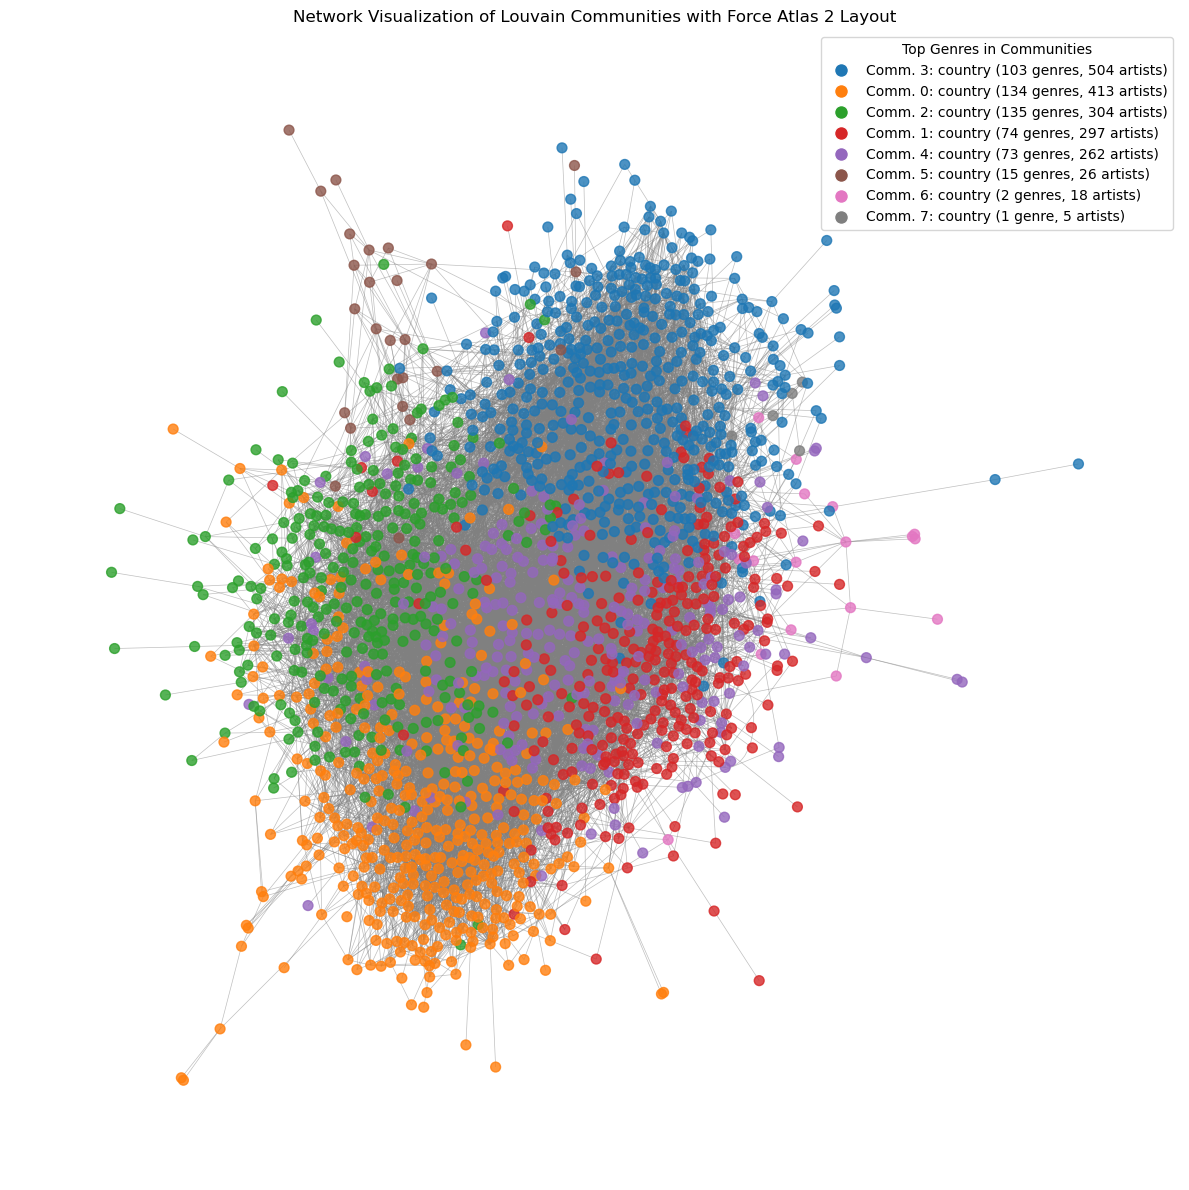

In [71]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import networkx as nx
from fa2_modified import ForceAtlas2

# Get the list of communities from the partition
community_ids = set(partition.values())

# Count the size of each community
community_sizes = Counter(partition.values())

# Sort the communities by size in descending order
sorted_communities = [community for community, size in community_sizes.most_common()]

# Create a dictionary to store genre counts per community
community_genres = defaultdict(lambda: defaultdict(int))

# Loop over all nodes to count genres within each community
for node, community in partition.items():
    genres = artist_genres.get(node, [])
    for genre in genres:
        community_genres[community][genre] += 1

# Create a dictionary to store the top genre and number of genres for each community
community_labels = {}

for community, genre_counts in community_genres.items():
    # Find the most frequent genre in the community
    top_genre = max(genre_counts, key=genre_counts.get)
    # Count the number of unique genres in the community
    num_genres = len(genre_counts)
    num_artists = community_sizes[community]

    if num_genres > 1:
        # Create a label in the format: "Top Genre (X genres)"
        community_labels[community] = f"Comm. {community}: {top_genre} ({num_genres} genres, {num_artists} artists)"
    else:
        community_labels[community] = f"Comm. {community}: {top_genre} ({num_genres} genre, {num_artists} artists)"

# Assign colors to communities based on sorted order (by size)
# Let's color only the top 10 largest communities
num_top_communities = 10
top_communities = sorted_communities[:num_top_communities]

# Use a color map that supports many colors
colors = plt.get_cmap('tab10')  # Supports up to 10 distinct colors
color_map = {community_id: colors(i) for i, community_id in enumerate(top_communities)}

# Assign a neutral color for the smaller communities
neutral_color = 'lightgray'

# Color nodes based on community
node_colors = []
for node in G.nodes():
    community_id = partition[node]
    if community_id in top_communities:
        node_colors.append(color_map[community_id])
    else:
        node_colors.append(neutral_color)  # Neutral color for smaller communities

# Compute the layout using Force Atlas 2
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    linLogMode=False,  # NOT lin-lin mode
    adjustSizes=False,  # Prevent overlap (NOT)
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,

    # Log
    verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

# Draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, positions, node_size=50, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, positions, edge_color='gray', alpha=0.5, width=0.5)
plt.axis("off")

# Add a legend with the top genres and number of genres per community
legend_labels = [community_labels[community_id] for community_id in top_communities]
handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[i],
                      markerfacecolor=color_map[top_communities[i]], markersize=10) for i in range(len(top_communities))]

plt.legend(handles=handles, loc="best", title="Top Genres in Communities")
plt.title("Network Visualization of Louvain Communities with Force Atlas 2 Layout")
plt.tight_layout()
plt.show()

**Comments on the result:** Even though the plot is scattered the community-partition is very much visible. The 4 common/larger communities mostly dominated the graph while there are 2 more communities present in the graph. Country music is the most common genre for all communities.

